In [49]:
import numpy as np
import scipy.linalg
import scipy.io
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from functools import partial

np.random.seed(seed=1)

%matplotlib inline

In [50]:
mat = scipy.io.loadmat("assign3.mat")
dat = [mat["a"].T, mat["b"].T]

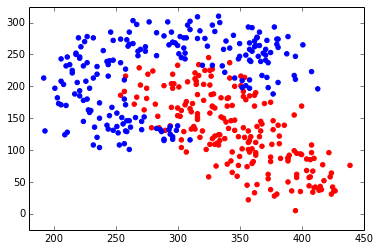

In [122]:
fig = plt.figure()
plt.scatter(dat[0][0], dat[0][1], color="red")
plt.scatter(dat[1][0], dat[1][1], color="blue")
plt.xlim(180, 450)
plt.ylim(-25, 325)

In [52]:
def med(c1, c2):
    """Create an med function"""
    z1 = np.mean(c1, axis=1)
    z2 = np.mean(c2, axis=1)
    def f(x):
        return -np.dot(z1,x) + 0.5*np.dot(z1.T,z1) < -np.dot(z2,x) + 0.5*np.dot(z2.T,z2)
    return f

In [72]:
def choose(dat, size):
    return dat[:, np.random.choice(dat.shape[1], size=size, replace=False)]

def get_diff(a, b):
    return np.where(a != b)[0]

def majority_vote(a, b, c):
    res = np.zeros(a.shape)
    res[np.where( np.sum((a, b, c), axis=0) >= 2 )] = 1
    return res

def make_booster(a_dat, b_dat, clsfier):
    # choose a quarter for training and classify
    a_err = np.empty((2,0))
    b_err = np.empty((2,0))
    while b_err.shape[1] <= 1 or a_err.shape[1] <= 1:
        c1 = clsfier(choose(a_dat, size=a_dat.shape[1]/4), choose(b_dat, size=b_dat.shape[1]/4))

        a_err = a_dat[:, np.where(c1(a_dat) == False)[0]]
        b_err = b_dat[:, np.where(c1(b_dat) == True)[0]]

    # choose a half of the erroroneously classed and train
    c2 = clsfier(choose(a_err, size=a_err.shape[1]/2), choose(b_err, size=b_err.shape[1]/2))

    # train on disagreement of c1 and c2
    a_c1 = c1(a_dat)
    a_c2 = c2(a_dat)
    b_c1 = c1(b_dat)
    b_c2 = c2(b_dat)
    
    a_diff = a_dat[:, get_diff(a_c1, a_c2)]
    b_diff = b_dat[:, get_diff(b_c1, b_c2)]
    c3 = clsfier(a_diff, b_diff)
    
    def boost_eval(x):
        return majority_vote(c1(x), c2(x), c3(x))
    
    return boost_eval

In [60]:
def make_q_class(c1, c2, q):
    err = []
    cls = []
    
    for q_i in xrange(q):
        # get the error
        a = choose(c1, 1)
        b = choose(c2, 1)
        cls.append(med(a, b))
        
        err.append(get_med_err(c1, c2, cls[-1]))

    return cls[np.argmin(err)]

In [65]:
def get_med_err(a, b, med_func):
    tot_err = 0
    tot_err += np.where(med_func(a) == False)[0].shape[0]
    tot_err += np.where(med_func(b) == True)[0].shape[0]
    return tot_err

In [74]:
ITER = 25

In [164]:
med_boost_err = []
mb_list = []
for _ in range(ITER):
    med_boosted = make_booster(dat[0], dat[1], med)
    mb_list.append(med_boosted)
    med_boost_err.append(get_med_err(dat[0], dat[1], med_boosted))

# Brent got 0.1902
print(np.mean(med_boost_err)/400.0)

0.2011


In [123]:
q_boost_err = []
qb_list = []
for _ in range(ITER):
    q_boosted = make_booster(dat[0], dat[1], partial(make_q_class, q=10))
    qb_list.append(q_boosted)
    q_boost_err.append(get_med_err(dat[0], dat[1], q_boosted))
# Brent got 0.16805
print(np.mean(q_boost_err)/400.0)

0.1764


In [133]:
# plot the q classifier boundary
n_points = 300
x = np.linspace(180, 450, n_points)
y = np.linspace(-25, 325, n_points)
X, Y = np.meshgrid(x, y)
res = qb_list[0](np.array([X.flatten(), Y.flatten()]))

In [141]:
qb_list

[<function __main__.boost_eval>,
 <function __main__.boost_eval>,
 <function __main__.boost_eval>,
 <function __main__.boost_eval>,
 <function __main__.boost_eval>,
 <function __main__.boost_eval>,
 <function __main__.boost_eval>,
 <function __main__.boost_eval>,
 <function __main__.boost_eval>,
 <function __main__.boost_eval>,
 <function __main__.boost_eval>,
 <function __main__.boost_eval>,
 <function __main__.boost_eval>,
 <function __main__.boost_eval>,
 <function __main__.boost_eval>,
 <function __main__.boost_eval>,
 <function __main__.boost_eval>,
 <function __main__.boost_eval>,
 <function __main__.boost_eval>,
 <function __main__.boost_eval>,
 <function __main__.boost_eval>,
 <function __main__.boost_eval>,
 <function __main__.boost_eval>,
 <function __main__.boost_eval>,
 <function __main__.boost_eval>]

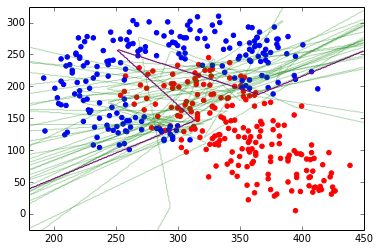

In [167]:
for qb in qb_list:
    res = qb(np.array([X.flatten(), Y.flatten()]))
    plt.contour(X, Y, res.reshape((300, 300)), levels=[0], alpha=0.3, colors="green")

best_qb = qb_list[np.argmin(q_boost_err)]
res = best_qb(np.array([X.flatten(), Y.flatten()]))
plt.contour(X, Y, res.reshape((300, 300)), levels=[0], alpha=1, colors="purple")


plt.scatter(dat[0][0], dat[0][1], color="red")
plt.scatter(dat[1][0], dat[1][1], color="blue")
plt.xlim(180, 450)
plt.ylim(-25, 325)
plt.savefig("countourq")

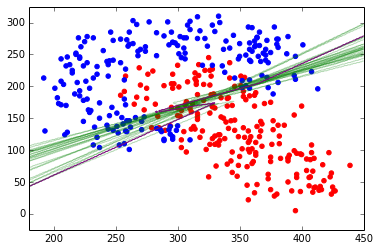

In [166]:
for mb in mb_list:
    res = mb(np.array([X.flatten(), Y.flatten()]))
    plt.contour(X, Y, res.reshape((300, 300)), levels=[0], alpha=0.3, colors="green")

best_mb = mb_list[np.argmin(med_boost_err)]
res = best_mb(np.array([X.flatten(), Y.flatten()]))
plt.contour(X, Y, res.reshape((300, 300)), levels=[0], alpha=1, colors="purple")


plt.scatter(dat[0][0], dat[0][1], color="red")
plt.scatter(dat[1][0], dat[1][1], color="blue")
plt.xlim(180, 450)
plt.ylim(-25, 325)
plt.savefig("countourm")

In [161]:
# explore the range of q, from 5 to 30
q_err = []
q_list = range(1, 5) + range(5, 35, 5)

for q_val in q_list:
    q_err.append([])
    for _ in range(25):
        q_tmp = make_booster(dat[0], dat[1], partial(make_q_class, q=q_val))
        q_err[-1].append(get_med_err(dat[0], dat[1], q_tmp))
print(q_err)

[[42, 106, 147, 69, 141, 85, 160, 105, 101, 92, 82, 93, 111, 82, 95, 101, 300, 87, 126, 101, 88, 120, 121, 89, 141], [57, 85, 93, 85, 95, 86, 62, 118, 72, 70, 59, 74, 105, 75, 75, 88, 76, 50, 90, 103, 63, 123, 110, 93, 90], [77, 104, 56, 73, 89, 81, 81, 81, 73, 106, 66, 77, 78, 72, 92, 81, 90, 56, 80, 79, 50, 78, 85, 75, 87], [59, 87, 85, 59, 70, 73, 83, 50, 71, 46, 76, 83, 100, 63, 89, 101, 89, 93, 83, 84, 77, 72, 80, 70, 91], [75, 72, 89, 78, 91, 85, 81, 94, 96, 83, 59, 83, 74, 49, 68, 69, 92, 90, 57, 95, 71, 71, 70, 56, 86], [76, 76, 67, 78, 67, 79, 77, 62, 79, 58, 51, 79, 63, 85, 73, 55, 64, 78, 63, 64, 83, 66, 78, 77, 68], [71, 60, 45, 80, 78, 84, 64, 93, 66, 67, 92, 73, 78, 48, 90, 58, 80, 74, 84, 44, 82, 55, 75, 59, 79], [60, 70, 74, 65, 72, 85, 66, 85, 65, 67, 63, 85, 75, 78, 74, 74, 57, 78, 51, 65, 77, 70, 71, 74, 48], [54, 52, 76, 64, 60, 61, 47, 81, 76, 76, 62, 60, 68, 49, 88, 79, 75, 42, 77, 58, 75, 66, 85, 65, 76], [64, 52, 81, 75, 59, 59, 75, 74, 77, 72, 76, 75, 76, 78, 8

In [154]:
q_err = np.array(q_err)
print(np.mean(q_err, axis=1).shape)
print(len(q_list))

(10,)
10


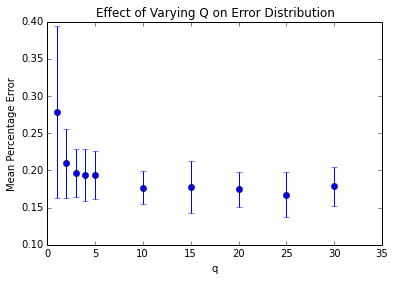

In [162]:
q_err = np.array(q_err)
plt.errorbar(q_list, np.mean(q_err, axis=1)/400.0, yerr=np.std(q_err, axis=1)/400.0, fmt='o')
plt.xlabel("q")
plt.ylabel("Mean Percentage Error")
plt.title("Effect of Varying Q on Error Distribution")
plt.savefig("varyq")

In [112]:
# unboosted q
q_def_err = []
for _ in range(ITER):
    q_default = make_q_class(dat[0], dat[1], 10)
    q_def_err.append(get_med_err(dat[0], dat[1], q_default))
print(np.mean(q_def_err)/400.0)

0.2133


In [113]:
# unboosted med
med_default = med(dat[0], dat[1])
med_def_err = get_med_err(dat[0], dat[1], med_default)
print(med_def_err/400.0)

0.205


In [114]:
# make a bar plot comparing various errors
err_mean = np.array([med_def_err, np.mean(med_boost_err), np.mean(q_def_err), np.mean(q_boost_err)])
err_std = np.array([0, np.std(med_boost_err), np.std(q_def_err), np.std(q_boost_err)])
err_label = ("MED", "MED Boosted", "Q", "Q boosted",)
ind = np.arange(len(err_mean))
bar_width = 0.4

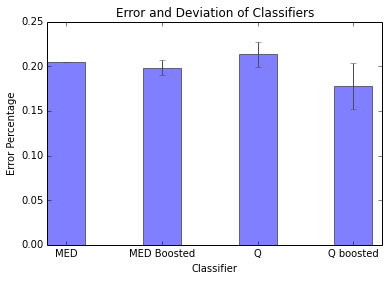

In [160]:
error_config = {'ecolor': '0.3'}
plt.bar(ind, err_mean/400.0, bar_width, alpha=0.5, yerr=err_std/400.0, error_kw=error_config)
plt.xlabel("Classifier")
plt.ylabel("Error Percentage")
plt.title("Error and Deviation of Classifiers")
plt.xticks(ind+bar_width/2.0, err_label)
plt.savefig("finalerror")